# Latent Dirichlet Allocation (LDA)

In [1]:
import os
import re
import json
import gensim
import pyLDAvis
import random

import numpy as np
import pandas as pd

from gensim.models.ldamulticore import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split
from gensim.models.coherencemodel import CoherenceModel

import lib.helper as helper

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import seaborn as sns
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
C:\ProgramData\Anaconda3\lib\site-packages\nltk\lm\vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "disaster" corpus works likewise, but with keywords relating to natural disasters

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [2]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 467
9.9 percent of files read.
19.7 percent of files read.
29.6 percent of files read.
39.4 percent of files read.
49.3 percent of files read.
59.1 percent of files read.
69.0 percent of files read.
78.8 percent of files read.
88.7 percent of files read.
98.5 percent of files read.
(115282, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Additional preprocessing for LDA

### TODO:  Dump the stuff below into another "embedding model" in lib

In [3]:
# A quick utility function to pre-process the text
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

corpus["tokens"] = corpus["clean_text"].apply(preprocess_desc)

corpus.tail()

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens
node,,,,,,,,,,
115277,1265598,Live updates as 999 crews rush to house fire t...,The road is currently closed,"Mon, 15 Jun 2020 13:27:02 +0000",https://www.lincolnshirelive.co.uk/news/lincol...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-16 10:34:18.834832,rss_feed,Live updates as crews rush to house fire that ...,"[live, updat, crew, rush, hous, close, busi, r..."
115278,1265599,Popular High Street shop announces it is reope...,Good news,"Mon, 15 Jun 2020 12:57:29 +0000",https://www.lincolnshirelive.co.uk/news/lincol...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-16 10:34:18.834832,rss_feed,Popular High Street shop announces it is reope...,"[popular, high, street, shop, announc, reopen,..."
115279,1265600,Huge queues at Primark as shoppers line up fro...,It's been a long time,"Mon, 15 Jun 2020 11:36:08 +0000",https://www.lincolnshirelive.co.uk/news/lincol...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-16 10:34:18.834832,rss_feed,Huge queues at Primark as shoppers line up fro...,"[huge, queue, primark, shopper, line, lincoln,..."
115280,1265601,Plan revealed to build 150 homes at troublespo...,The area has become a hotspot for anti-social ...,"Mon, 15 Jun 2020 11:23:32 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-16 10:34:18.834832,rss_feed,Plan revealed to build 150 homes at troublespo...,"[plan, reveal, build, home, troublespot, teen,..."
115281,1265604,Polo club plans that sparked flood of complain...,More than 80 people had objected to the plans,"Mon, 15 Jun 2020 10:09:33 +0000",https://www.lincolnshirelive.co.uk/news/local-...,http://lincolnshirelive.co.uk/news/?service=rss,2020-06-16 10:34:18.834832,rss_feed,Polo club plans that sparked flood of complain...,"[polo, club, plan, spark, flood, complaint, ap..."


In [4]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(corpus['tokens'])

# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus['tokens']]

# From that create the TF-IDF model
# THIS IS ANOTHER POINT THE CORPUS ORDERING COULD DETATCH FROM THE RAW DATA ORDERING
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus['corpus_tfidf'] = tfidf[bow_corpus]

corpus['corpus_tfidf'].head()

node
0    [(0, 0.5850984139020627), (1, 0.18451914879930...
1    [(15, 0.26497409263404426), (16, 0.33973621615...
2    [(29, 0.18836542473144396), (30, 0.12821447218...
3    [(27, 0.2192944074324671), (42, 0.321048988372...
4    [(53, 0.21553931075900315), (54, 0.19628534536...
Name: corpus_tfidf, dtype: object

## 3. Testing a range of different-sized LDA models

In [17]:
random.seed(7)
trainset, testset = train_test_split(corpus, test_size=0.15)

In [18]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()
for num_topics in range(3, 101):

    # Fit the lda model, with [num_topics] topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("working/disaster_lda_stats_clean.csv")

tried 3 topics perplexity = -9.717070055431488 coherence = -3.275418169279624
tried 4 topics perplexity = -9.98696780137105 coherence = -3.918239309327092
tried 5 topics perplexity = -10.31632201701593 coherence = -5.641808833341678
tried 6 topics perplexity = -10.523428508610781 coherence = -6.711458481706693
tried 7 topics perplexity = -10.741742861559784 coherence = -7.543547893846557
tried 8 topics perplexity = -10.934949187999004 coherence = -7.410943799692644
tried 9 topics perplexity = -11.213029324094038 coherence = -8.890806943827421
tried 10 topics perplexity = -11.521388104323158 coherence = -8.74814174162655
tried 11 topics perplexity = -11.978111746344286 coherence = -8.807782415232436
tried 12 topics perplexity = -12.450271408993284 coherence = -9.209376643957297
tried 13 topics perplexity = -12.844158813579533 coherence = -8.74743741182825
tried 14 topics perplexity = -13.091062029935214 coherence = -9.495897328157296
tried 15 topics perplexity = -13.367202813604624 cohe

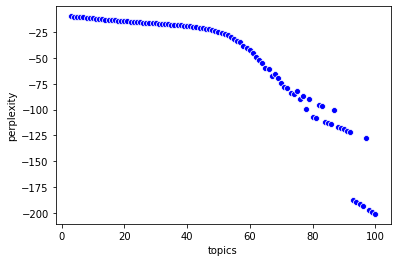

In [19]:
# plot the results - PERPLEXITY
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

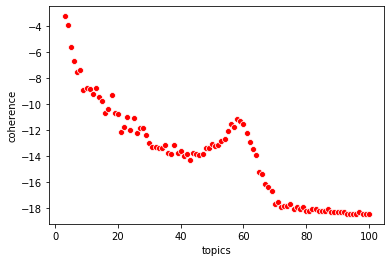

In [20]:
# plot the results - COHERENCE
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 4. Create the "best" model using all data

And parameters decided by test-time performance on perplexity and coherence.

In [5]:
random.seed(10)

# Fit the final lda model to all data
lda_model_tfidf = LdaModel(corpus['corpus_tfidf'],
                           num_topics=58,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(corpus['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=corpus['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

lda_model_tfidf.save("working/lda_model_tfidf.model")

perplexity = -40.34930734161795 coherence = -6.790300322808077


In [22]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.072*"minist" + 0.064*"state" + 0.051*"prime" + 0.049*"need" + 0.038*"governor" + 0.036*"parti" + 0.035*"site" + 0.034*"unit" + 0.034*"itali" + 0.031*"visit"
Topic: 1 Word: 0.069*"week" + 0.068*"allow" + 0.045*"nearli" + 0.044*"ve" + 0.043*"pass" + 0.041*"life" + 0.041*"univers" + 0.036*"away" + 0.035*"hospit" + 0.031*"member"
Topic: 2 Word: 0.073*"murder" + 0.044*"safe" + 0.037*"david" + 0.032*"mr" + 0.030*"know" + 0.030*"sell" + 0.030*"arrest" + 0.030*"justic" + 0.029*"respond" + 0.029*"blame"
Topic: 3 Word: 0.156*"china" + 0.063*"major" + 0.063*"suffer" + 0.062*"global" + 0.058*"step" + 0.049*"threat" + 0.037*"tree" + 0.033*"eye" + 0.032*"educ" + 0.028*"detain"
Topic: 4 Word: 0.065*"kent" + 0.063*"continu" + 0.056*"biden" + 0.046*"joe" + 0.046*"concern" + 0.033*"german" + 0.027*"book" + 0.025*"get" + 0.023*"class" + 0.023*"race"
Topic: 5 Word: 0.061*"save" + 0.055*"doctor" + 0.054*"babi" + 0.053*"garden" + 0.052*"medic" + 0.047*"given" + 0.045*"water" + 0.045*"aid" +

In [23]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)
    
topic_word_dist

,keywords,topic
0,minist state prime need governor,X0
1,week allow nearli ve pass,X1
2,murder safe david mr know,X2
3,china major suffer global step,X3
4,kent continu biden joe concern,X4
5,save doctor babi garden medic,X5
6,march restaur incid look food,X6
7,store remain pm base gener,X7
8,help record end vehicl final,X8
9,york andrew fear critic princ,X9


In [6]:
# Assign topic to document, also store the probability of that topic
doc_topics = []

count = 0
for index, row in corpus.iterrows():
    
    # Extract list of tuples of (topic, score) from the model for each doc
    topics = [x for x in lda_model_tfidf.get_document_topics(row['corpus_tfidf']) ]
    
    # Find the highest probability topic
    highest_scoring = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    
    temp = {"node": int(index),
            "cluster": highest_scoring[0],
            "score": highest_scoring[1]}
    
    # Report processing progress!
    count = count + 1
    if count % 10000 == 0:
        print(count)
    
    doc_topics.append(temp)

doc_topic_dist = pd.DataFrame(doc_topics).set_index("node")

doc_topic_dist.to_csv("working/doc_topic_dist_backup.csv")

doc_topic_dist.head()

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000


,cluster,score
node,,
0,40,0.393337
1,38,0.242703
2,31,0.213347
3,16,0.248596
4,2,0.227043


In [7]:
corpus.join(doc_topic_dist).to_csv("working/RSS_clustered_lda.csv", index=False)

### Looking at the topic distribution, there's no obvious way to draw a line and cut off outliers

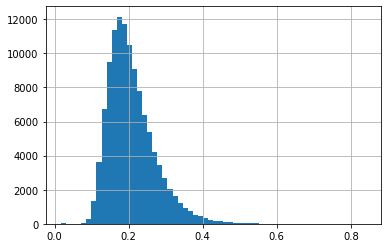

In [13]:
corpus.join(doc_topic_dist)['score'].hist(bins=60)